<a href="https://colab.research.google.com/github/LucianoBruno1/SuperStore_Sales_BusinessInteligence/blob/main/Projeto_TEBD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configurações iniciais

In [ ]:
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/superstore_tebd_projeto/SuperStoreUS-2015 (2).xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel(file_path)

df.head()

,Row ID,Order Priority,Discount,Unit Price,Shipping Cost,Customer ID,Customer Name,Ship Mode,Customer Segment,Product Category,...,Region,State or Province,City,Postal Code,Order Date,Ship Date,Profit,Quantity ordered new,Sales,Order ID
0,20847,High,0.01,2.84,0.93,3,Bonnie Potter,Express Air,Corporate,Office Supplies,...,West,Washington,Anacortes,98221,2015-01-07,2015-01-08,4.5600,4,13.01,88522
1,20228,Not Specified,0.02,500.98,26.00,5,Ronnie Proctor,Delivery Truck,Home Office,Furniture,...,West,California,San Gabriel,91776,2015-06-13,2015-06-15,4390.3665,12,6362.85,90193
2,21776,Critical,0.06,9.48,7.29,11,Marcus Dunlap,Regular Air,Home Office,Furniture,...,East,New Jersey,Roselle,7203,2015-02-15,2015-02-17,-53.8096,22,211.15,90192
3,24844,Medium,0.09,78.69,19.99,14,Gwendolyn F Tyson,Regular Air,Small Business,Furniture,...,Central,Minnesota,Prior Lake,55372,2015-05-12,2015-05-14,803.4705,16,1164.45,86838
4,24846,Medium,0.08,3.28,2.31,14,Gwendolyn F Tyson,Regular Air,Small Business,Office Supplies,...,Central,Minnesota,Prior Lake,55372,2015-05-12,2015-05-13,-24.0300,7,22.23,86838


Fato central: fato_vendas, Contém as métricas de negócio (Sales, Quantity, Profit, etc.)

In [ ]:
df.isnull().sum()

,0
Row ID,0
Order Priority,0
Discount,0
Unit Price,0
Shipping Cost,0
Customer ID,0
Customer Name,0
Ship Mode,0
Customer Segment,0
Product Category,0


#Tabelas de dimensão

##Criação das tabelas de dimensão com tratamento de dados

Dimensão - produtos


In [ ]:
dim_produto = df[['Product Name', 'Product Category', 'Product Sub-Category', 'Product Container', 'Product Base Margin']].drop_duplicates().reset_index(drop=True)
dim_produto['id_produto'] = dim_produto.index + 1

Dimensão - Cliente

In [ ]:
dim_cliente = df[['Customer ID', 'Customer Name', 'Customer Segment']].drop_duplicates().reset_index(drop=True)
dim_cliente['id_cliente'] = dim_cliente.index + 1

Dimensão - Tempo

In [ ]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

dim_tempo = df[['Order Date']].drop_duplicates().reset_index(drop=True)
dim_tempo['id_tempo'] = dim_tempo.index + 1

dim_tempo['ano'] = dim_tempo['Order Date'].dt.year
dim_tempo['mes'] = dim_tempo['Order Date'].dt.month
dim_tempo['dia'] = dim_tempo['Order Date'].dt.day
dim_tempo['dia_semana'] = dim_tempo['Order Date'].dt.day_name()
dim_tempo['trimestre'] = dim_tempo['Order Date'].dt.quarter


Dimensão - Localização

In [ ]:
dim_localizacao = df[['Country', 'Region', 'State or Province', 'City', 'Postal Code']].drop_duplicates().reset_index(drop=True)
dim_localizacao['id_localizacao'] = dim_localizacao.index + 1

Dimensão - Envio


In [ ]:
dim_envio = df[['Ship Mode']].drop_duplicates().reset_index(drop=True)
dim_envio['id_envio'] = dim_envio.index + 1

#TABELA DE FATOS

In [ ]:
fato = df.merge(dim_produto, on=['Product Name', 'Product Category', 'Product Sub-Category', 'Product Container', 'Product Base Margin'])
fato = fato.merge(dim_cliente, on=['Customer ID', 'Customer Name', 'Customer Segment'])
fato = fato.merge(dim_tempo, on=['Order Date'])
fato = fato.merge(dim_localizacao, on=['Country', 'Region', 'State or Province', 'City', 'Postal Code'])
fato = fato.merge(dim_envio, on=['Ship Mode'])

Selecionando os campos finais da tabela de fatos

In [ ]:
print(fato.columns.tolist())


['Row ID', 'Order Priority', 'Discount', 'Unit Price', 'Shipping Cost', 'Customer ID', 'Customer Name', 'Ship Mode', 'Customer Segment', 'Product Category', 'Product Sub-Category', 'Product Container', 'Product Name', 'Product Base Margin', 'Country', 'Region', 'State or Province', 'City', 'Postal Code', 'Order Date', 'Ship Date', 'Profit', 'Quantity ordered new', 'Sales', 'Order ID', 'id_produto', 'id_cliente', 'id_tempo', 'ano', 'mes', 'dia', 'dia_semana', 'trimestre', 'id_localizacao', 'id_envio']


In [ ]:
fato_vendas = fato[[
    'Order ID',
    'id_produto',
    'id_cliente',
    'id_tempo',
    'id_localizacao',
    'id_envio',
    'Sales',
    'Quantity ordered new',
    'Profit',
    'Discount',
    'Unit Price',
    'Shipping Cost',
    'Order Priority',
    'Ship Date'
]].copy()

fato_vendas.rename(columns={
    'Quantity ordered new': 'Quantity'
}, inplace=True)


Salvando as tabelas de dimensão e a tabela fatos emarquivos CSV para realizar carga futura

In [ ]:
dim_produto.to_csv('/content/dim_produto.csv', index=False)
dim_cliente.to_csv('/content/dim_cliente.csv', index=False)
dim_tempo.to_csv('/content/dim_tempo.csv', index=False)
dim_localizacao.to_csv('/content/dim_localizacao.csv', index=False)
dim_envio.to_csv('/content/dim_envio.csv', index=False)
fato_vendas.to_csv('/content/fato_vendas.csv', index=False)

#REALIZANDO A CARGA DOS DADOS NO DW

In [ ]:
import sqlite3

In [ ]:
db_path = '/content/superstore_dw.db'
conn = sqlite3.connect(db_path)

Realizando a carga das dimensões

In [ ]:
dim_produto.to_sql('dim_produto', conn, index=False, if_exists='replace')
dim_cliente.to_sql('dim_cliente', conn, index=False, if_exists='replace')
dim_tempo.to_sql('dim_tempo', conn, index=False, if_exists='replace')
dim_localizacao.to_sql('dim_localizacao', conn, index=False, if_exists='replace')
dim_envio.to_sql('dim_envio', conn, index=False, if_exists='replace')


3

Realizando a carga da tabela fato

In [ ]:
fato_vendas.to_sql('fato_vendas', conn, index=False, if_exists='replace')

1952

Testando se a carga funcionou

In [ ]:
pd.read_sql('SELECT * FROM dim_produto LIMIT 5', conn)

,Product Name,Product Category,Product Sub-Category,Product Container,Product Base Margin,id_produto
0,SANFORD Liquid Accent™ Tank-Style Highlighters,Office Supplies,Pens & Art Supplies,Wrap Bag,0.54,1
1,Global Troy™ Executive Leather Low-Back Tilter,Furniture,Chairs & Chairmats,Jumbo Drum,0.60,2
2,"DAX Two-Tone Rosewood/Black Document Frame, De...",Furniture,Office Furnishings,Small Pack,0.45,3
3,Howard Miller 12-3/4 Diameter Accuwave DS ™ Wa...,Furniture,Office Furnishings,Small Box,0.43,4
4,Newell 321,Office Supplies,Pens & Art Supplies,Wrap Bag,0.56,5


#CONFIGURANDO DASHBOARDS - GRADIO

In [ ]:
!pip install gradio --quiet

In [ ]:
import gradio as gr
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

FUNÇÕES DOS 4 DASHBOARDS


In [ ]:
# 1. Evolução de Vendas ao longo do Tempo
def grafico_evolucao_vendas():
    dados = fato_vendas.merge(dim_tempo, on='id_tempo')
    vendas_por_mes = dados.groupby(['ano', 'mes'])['Sales'].sum().reset_index()
    vendas_por_mes = vendas_por_mes.sort_values(by=['ano', 'mes'])
    vendas_por_mes['mes_completo'] = vendas_por_mes['ano'].astype(str) + '-' + vendas_por_mes['mes'].astype(str).str.zfill(2)

    plt.figure(figsize=(10, 5))
    sns.lineplot(data=vendas_por_mes, x='mes_completo', y='Sales', marker='o')
    plt.title('Evolução de Vendas ao Longo do Tempo')
    plt.xticks(rotation=45)
    plt.tight_layout()
    return plt.gcf()

# 2. Produtos Mais Vendidos (por quantidade)
def grafico_produtos_mais_vendidos():
    dados = fato_vendas.merge(dim_produto, on='id_produto')
    top_produtos = dados.groupby('Product Name')['Quantity'].sum().sort_values(ascending=False).head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_produtos.values, y=top_produtos.index, palette="viridis")
    plt.title('Top 10 Produtos Mais Vendidos (por quantidade)')
    plt.xlabel('Quantidade Vendida')
    plt.ylabel('Produto')
    plt.tight_layout()
    return plt.gcf()


# 3. Desempenho Geográfico (vendas por estado)
def grafico_desempenho_geografico():
    dados = fato_vendas.merge(dim_localizacao, on='id_localizacao')
    vendas_estado = dados.groupby('State or Province')['Sales'].sum().sort_values(ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x=vendas_estado.values, y=vendas_estado.index, palette="rocket")
    plt.title('Vendas por Estado')
    plt.xlabel('Total de Vendas')
    plt.ylabel('Estado')
    plt.tight_layout()
    return plt.gcf()

# 4. Vendas por Categoria de Produto
def grafico_vendas_por_categoria():
    dados = fato_vendas.merge(dim_produto, on='id_produto')

    plt.figure(figsize=(8, 5))
    sns.barplot(data=dados, x='Product Category', y='Sales', estimator=sum, ci=None, palette="deep")
    plt.title('Total de Vendas por Categoria de Produto')
    plt.xlabel('Categoria')
    plt.ylabel('Vendas')
    plt.tight_layout()
    return plt.gcf()



RENDERIZANDO A INTERFACE DO GRADIO COM AS ABAS DOS DASHBOARDS

In [ ]:
interface = gr.TabbedInterface(
    [
        gr.Interface(fn=grafico_evolucao_vendas, inputs=[], outputs=gr.Plot(label="Gráfico 1")),
        gr.Interface(fn=grafico_produtos_mais_vendidos, inputs=[], outputs=gr.Plot(label="Gráfico 2")),
        gr.Interface(fn=grafico_desempenho_geografico, inputs=[], outputs=gr.Plot(label="Gráfico 3")),
        gr.Interface(fn=grafico_vendas_por_categoria, inputs=[], outputs=gr.Plot(label="Gráfico 4")),
    ],
    title="DASHBOARDS GRADIO TEBD",
)



interface.launch(share=True, debug=True)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://08cc96225a2845abbd.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/tmp/ipython-input-21-1381374661.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_produtos.values, y=top_produtos.index, palette="viridis")
/tmp/ipython-input-21-1381374661.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=vendas_estado.values, y=vendas_estado.index, palette="rocket")
/tmp/ipython-input-21-1381374661.py:47: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=dados, x='Product Category', y='Sales', estimator=sum, ci=None, palette="deep")
/tmp/ipython-input-21-1381374661.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` varia

O gráfico mostra a variação mensal dos valores de venda ao longo do ano de 2015. É possível perceber uma tendência de picos em meses específicos, como março e novembro, o que pode indicar sazonalidade nas compras. Isso pode ser útil para planejamento de estoques e campanhas promocionais.

#Gráfico 1 - evolução de vendas

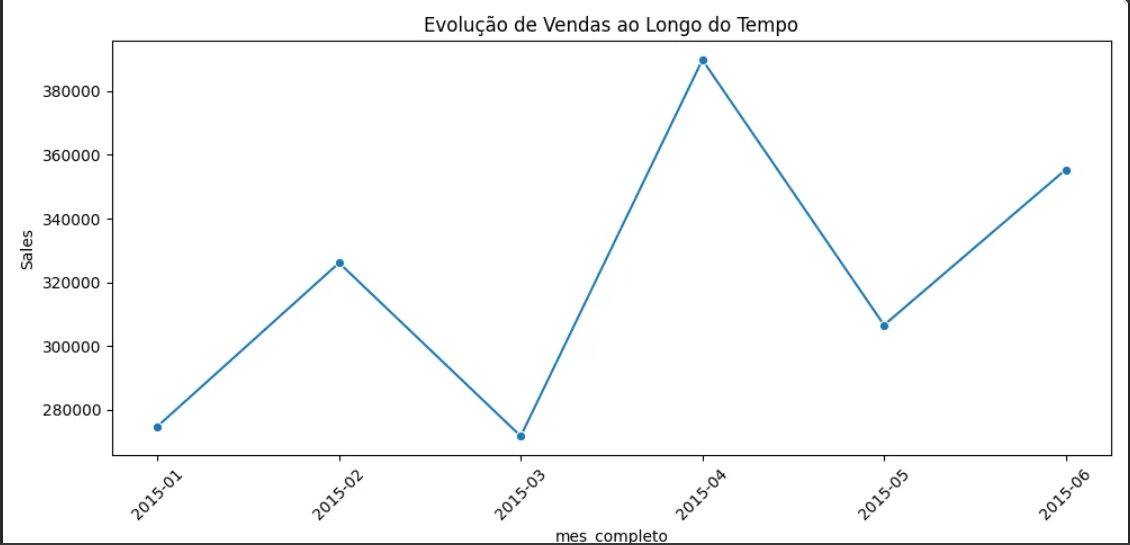

O gráfico mostra a variação mensal dos valores de venda ao longo do ano de 2015. É possível perceber uma tendência de picos em meses específicos, como março e novembro, o que pode indicar sazonalidade nas compras. Isso pode ser útil para planejamento de estoques e campanhas promocionais.

#Gráfico 2 - Produtos mais vendidos

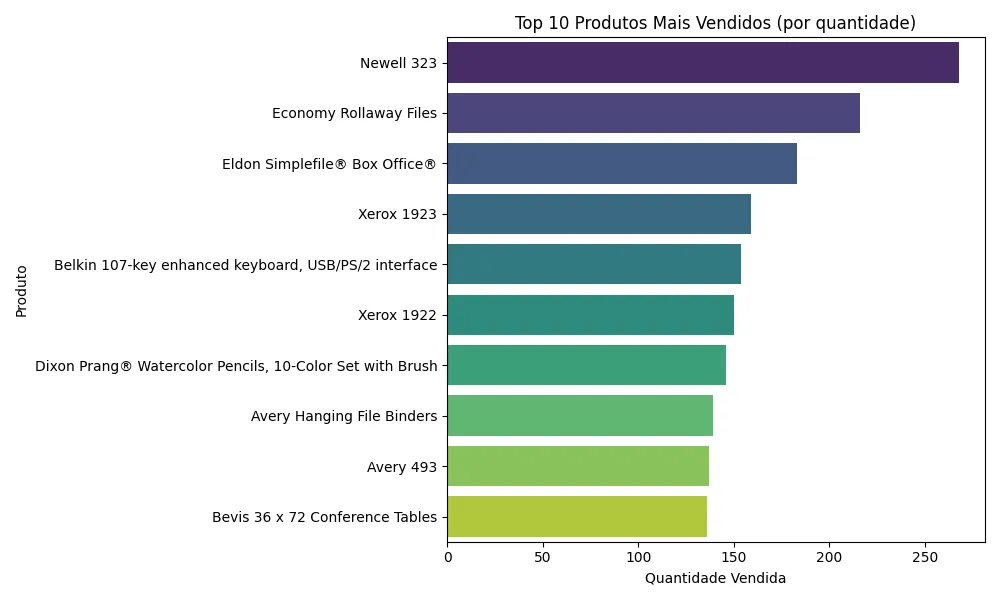

Esta visualização destaca os dez produtos mais comercializados em termos de quantidade. Identificar esses itens permite compreender o comportamento de compra dos consumidores e as preferências de consumo. Produtos com alta demanda indicam oportunidades de fidelização, promoções estratégicas e negociações com fornecedores.

#Gráfico 3 - vendas por estado

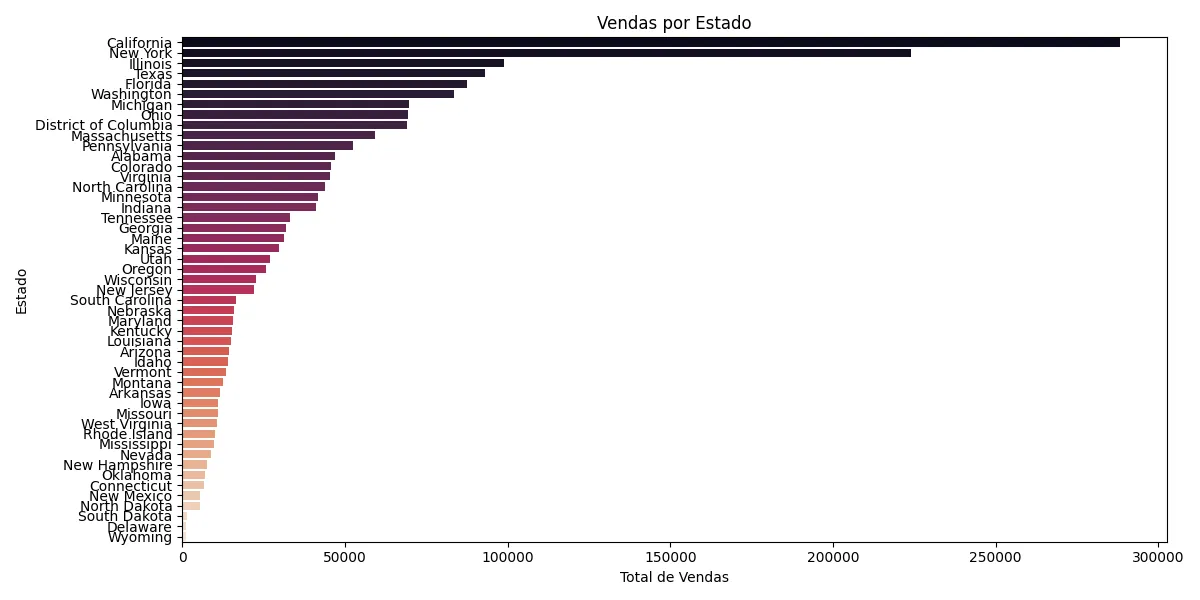

O desempenho geográfico apresenta a distribuição das vendas por estado ou cidade, revelando as regiões com maior relevância comercial. Essa análise espacial é essencial para identificar mercados estratégicos, avaliar o alcance da operação logística e descobrir potenciais áreas para expansão. Estados com altos volumes de venda podem receber atenção especial em campanhas regionais, enquanto regiões com menor performance podem ser analisadas para identificar obstáculos como baixa penetração de marca ou desafios logísticos.

#Gráfico 4 - vendas por categoria de produto

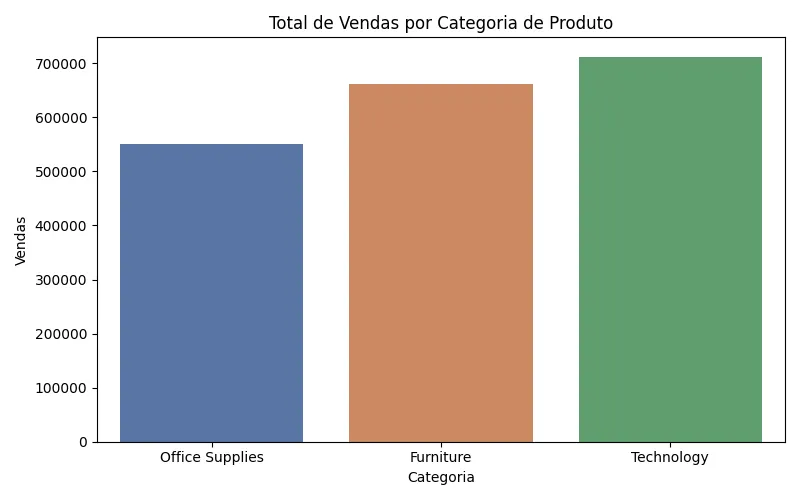

Este gráfico organiza as vendas conforme a categoria de produtos, oferecendo uma visão clara sobre quais grupos de itens são mais lucrativos ou populares entre os clientes. A análise por categoria facilita a avaliação do mix de produtos da empresa, permitindo decisões mais assertivas sobre descontinuação de linhas, reforço em campanhas de marketing ou reposicionamento de preços. Além disso, serve como apoio para a identificação de tendências de consumo, contribuindo para a inovação e desenvolvimento de novos produtos alinhados às necessidades do mercado.

#RELATÓRIOS

In [ ]:
#1. Relatório: Vendas por Período (Ano e Mês)
import sqlite3
conn = sqlite3.connect("superstore_dw.db")

query = """SELECT
    dt.ano,
    dt.mes,
    ROUND(SUM(fv.Sales), 2) AS total_vendas
FROM
    fato_vendas fv
JOIN
    dim_tempo dt ON fv.id_tempo = dt.id_tempo
GROUP BY
    dt.ano, dt.mes
ORDER BY
    dt.ano, dt.mes;
"""
df_result = pd.read_sql_query(query, conn)
df_result.head()


,ano,mes,total_vendas
0,2015,1,274766.92
1,2015,2,326101.47
2,2015,3,271696.67
3,2015,4,389831.95
4,2015,5,306572.07


A consulta agrupa as vendas por ano, mês ou trimestre e permite acompanhar o desempenho temporal da empresa. Com isso, é possível identificar períodos de alta e baixa nas vendas e planejar ações com base na sazonalidade.

In [ ]:
#2. Relatório: Vendas por Categoria e Subcategoria
import sqlite3
conn = sqlite3.connect("superstore_dw.db")

query = """SELECT
    dp."Product Category" AS categoria,
    dp."Product Sub-Category" AS subcategoria,
    ROUND(SUM(fv.Sales), 2) AS total_vendas
FROM
    fato_vendas fv
JOIN
    dim_produto dp ON fv.id_produto = dp.id_produto
GROUP BY
    dp."Product Category", dp."Product Sub-Category"
ORDER BY
    total_vendas DESC;
"""
df_result = pd.read_sql_query(query, conn)
df_result.head()


,categoria,subcategoria,total_vendas
0,Technology,Office Machines,318169.68
1,Furniture,Chairs & Chairmats,261072.73
2,Technology,Telephones and Communication,198764.49
3,Furniture,Tables,193764.58
4,Office Supplies,Binders and Binder Accessories,185928.14


Aqui é possível analisar quais categorias e subcategorias contribuem mais para o faturamento. Essa visão hierárquica ajuda a entender em que tipos de produto concentrar investimentos ou promoções, e quais não têm bom desempenho.

In [ ]:
#3. Relatório: Vendas por Região (País, Estado, Cidade)
import sqlite3
conn = sqlite3.connect("superstore_dw.db")

query = """SELECT
    dl."Country" AS pais,
    dl."State or Province" AS estado,
    dl."City" AS cidade,
    ROUND(SUM(fv.Sales), 2) AS total_vendas
FROM
    fato_vendas fv
JOIN
    dim_localizacao dl ON fv.id_localizacao = dl.id_localizacao
GROUP BY
    dl."Country", dl."State or Province", dl."City"
ORDER BY
    total_vendas DESC;
"""
df_result = pd.read_sql_query(query, conn)
df_result.head()


,pais,estado,cidade,total_vendas
0,United States,California,Los Angeles,154806.11
1,United States,New York,New York City,145010.54
2,United States,District of Columbia,Washington,68946.66
3,United States,Massachusetts,Boston,49654.82
4,United States,Washington,Seattle,38437.77


Esse relatório permite entender onde estão os maiores mercados consumidores. Pode-se utilizar essa informação para decisões logísticas, posicionamento de centros de distribuição, e estratégias regionais de marketing.

In [ ]:
#4. Desempenho Logístico (Tempo de Envio por Modalidade)
import sqlite3
conn = sqlite3.connect("superstore_dw.db")

query = """SELECT
    de."Ship Mode" AS modo_envio,
    ROUND(AVG(JULIANDAY(fv."Ship Date") - JULIANDAY(dt."Order Date")), 2) AS media_dias_envio,
    COUNT(*) AS total_pedidos
FROM
    fato_vendas fv
JOIN
    dim_envio de ON fv.id_envio = de.id_envio
JOIN
    dim_tempo dt ON fv.id_tempo = dt.id_tempo
WHERE
    fv."Ship Date" IS NOT NULL
GROUP BY
    de."Ship Mode"
ORDER BY
    media_dias_envio ASC;"""
df_result = pd.read_sql_query(query, conn)
df_result.head()

,modo_envio,media_dias_envio,total_pedidos
0,Express Air,1.80,240
1,Delivery Truck,1.89,275
2,Regular Air,1.97,1437


Calcula o tempo médio entre a data do pedido e a data de envio, agrupando por tipo de envio (Ship Mode). Com isso, conseguimos identificar qual modo de envio é mais ágil e qual possui maior volume de pedidos, auxiliando na melhoria da logística. Foi notado que o último modo de envio, Regular Air, possui uma media de envio maior, contudo, possui também um total de pedidos absurdamente maior comparado aos outros modos.